In [1]:
from __future__ import annotations

from typing import List, Iterable, Dict
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from docplex.cp.model import CpoModel, CpoVariable, SOLVE_STATUS_FEASIBLE, SOLVE_STATUS_OPTIMAL

from src.core.core import server_task_allocation
from src.extra.io import ImageFormat, save_plot
from src.core.core import reset_model
from src.core.non_elastic_task import NonElasticTask, SumSpeedsResourcePriority
from src.core.server import Server
from src.core.elastic_task import ElasticTask
from src.greedy.greedy import greedy_algorithm
from src.greedy.resource_allocation import SumPowPercentage
from src.greedy.server_selection import ProductResources
from src.greedy.task_priority import UtilityDeadlinePerResourcePriority
from src.optimal.non_elastic_optimal import non_elastic_optimal
from src.optimal.elastic_optimal import elastic_optimal

In [3]:
matplotlib.rcParams['font.family'] = 'monospace'
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
# matplotlib.rc('font', weight='bold')

### Model Setting

In [4]:
tasks = [
    ElasticTask("Task 1",  required_storage=100, required_computation=100, required_results_data=50, deadline=10, value=100),
    ElasticTask("Task 2",  required_storage=75,  required_computation=125, required_results_data=40, deadline=10, value=90),
    ElasticTask("Task 3",  required_storage=125, required_computation=110, required_results_data=45, deadline=10, value=110),
    ElasticTask("Task 4",  required_storage=100, required_computation=75,  required_results_data=60, deadline=10, value=75),
    ElasticTask("Task 5",  required_storage=85,  required_computation=90,  required_results_data=55, deadline=10, value=125),
    ElasticTask("Task 6",  required_storage=75,  required_computation=120, required_results_data=40, deadline=10, value=100),
    ElasticTask("Task 7",  required_storage=125, required_computation=100, required_results_data=50, deadline=10, value=80),
    ElasticTask("Task 8",  required_storage=115, required_computation=75,  required_results_data=55, deadline=10, value=110),
    ElasticTask("Task 9",  required_storage=100, required_computation=110, required_results_data=60, deadline=10, value=120),
    ElasticTask("Task 10", required_storage=90,  required_computation=120, required_results_data=40, deadline=10, value=90),
    ElasticTask("Task 11", required_storage=110, required_computation=90,  required_results_data=45, deadline=10, value=100),
    ElasticTask("Task 12", required_storage=100, required_computation=80,  required_results_data=55, deadline=10, value=100)
]

servers = [
    Server("Server 1", storage_capacity=500, computation_capacity=90, bandwidth_capacity=220),
    Server("Server 2", storage_capacity=500, computation_capacity=90, bandwidth_capacity=210),
    Server("Server 3", storage_capacity=500, computation_capacity=90, bandwidth_capacity=250)
]

In [5]:
def print_tasks(tasks: List[ElasticTask]):
    print(f'Social welfare: {sum(task.value for task in tasks if task.running_server)}, '
          f'percentage tasks allocated: {sum(task.running_server is not None for task in tasks)}')
    max_task_name_len = max(len(task.name) for task in tasks) + 1
    print("{:<{}}| Value |{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}| {}"
          .format("Name", max_task_name_len, "Storage", "Computation", "Results", "Deadline", 
                  "Loading", "Compute", "Sending", "Server"))
    
    for task in tasks:
        print("{:<{name_len}}|{:^7.1f}|{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}|{:^10}"
              .format(task.name, task.value, task.required_storage, task.required_computation, task.required_results_data,
                      task.deadline, task.loading_speed, task.compute_speed, task.sending_speed,
                      task.running_server.name if task.running_server else "None", name_len=max_task_name_len))

### Plot allocation results

In [6]:
def plot_allocation_results(tasks: List[ElasticTask], servers: List[Server], title: str, 
                            large_txt: int = 14, small_txt: int = 12,
                            image_formats: Iterable[ImageFormat] = (ImageFormat.PNG,)):
    """
    Plots the allocation results

    :param tasks: List of tasks
    :param servers: List of servers
    :param title: The title
    """

    allocated_tasks = [task for task in tasks if task.running_server]
    loading_df = pd.DataFrame(
        [[task.required_storage / server.storage_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    compute_df = pd.DataFrame(
        [[task.compute_speed / server.computation_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    sending_df = pd.DataFrame(
        [[(task.loading_speed + task.sending_speed) / server.bandwidth_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    resources_df = [loading_df, compute_df, sending_df]

    n_col, n_ind = len(resources_df[0].columns), len(resources_df[0].index)
    hatching = '\\'

    fig, axe = plt.subplots(figsize=(7, 4))
    for resource_df in resources_df:  # for each data frame
        axe = resource_df.plot(kind='bar', linewidth=0, stacked=True, ax=axe, legend=False, grid=False)

    h, _l = axe.get_legend_handles_labels()  # get the handles we want to modify
    colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'orange',
               'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'pink']
    for i in range(0, 3 * n_col, n_col):
        for j, pa in enumerate(h[i:i + n_col]):
            for rect in pa.patches:
                # print(pa, pa.patches, rect)
                rect.set_x(rect.get_x() + 1 / float(3 + 1) * i / float(n_col) - 0.125)
                rect.set_facecolor(colours[j])
                rect.set_hatch(hatching * int(i / n_col))
                rect.set_width(1 / float(3 + 1))

    axe.set_xlabel('Servers', fontsize=large_txt, fontweight='semibold')
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(3 + 1)) / 2. - 0.125)
    axe.set_xticklabels(resources_df[0].index, rotation=0, fontsize=small_txt)

    axe.set_ylabel('Resource Usage', fontsize=large_txt, fontweight='semibold')
    axe.set_ylim((0.0, 1.0))
    axe.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axe.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=small_txt)

    pos = 1 - 0.0625 * sum(task.running_server is not None for task in tasks) - 0.08
    server_resources_legend = [axe.bar(0, 0, color="gray", hatch=hatching * i) for i in range(3)]
    tasks_legend = axe.legend(h[:n_col], _l[:n_col], loc=[1.025, pos], title='$\\bf{Tasks}$')  # 0.17
    plt.legend(server_resources_legend, ['Storage', 'Computation', 'Bandwidth'],
               loc=[1.025, pos - 0.29], title='$\\bf{Server~resources}$')  # -0.12
    axe.add_artist(tasks_legend)

    plt.tight_layout()

    save_plot(title.lower().replace(' ', '_'), image_formats=image_formats)
    plt.show()

### Minimise flexible resource allocation

In [7]:
def minimise_resource_allocation(tasks: List[ElasticTask], servers: List[Server], time_limit: int = 1):
    """
    Minimise resource allocation of a list of servers

    :param tasks: List of new tasks to the server (this is important for the online flexible case)
    :param servers: List of servers
    :param time_limit: Solve time limit
    """
    for server in servers:
        server_new_tasks = [task for task in server.allocated_tasks if task in tasks]
        model = CpoModel('MinimumAllocation')

        loading_speeds: Dict[ElasticTask, CpoVariable] = {}
        compute_speeds: Dict[ElasticTask, CpoVariable] = {}
        sending_speeds: Dict[ElasticTask, CpoVariable] = {}

        # The maximum bandwidth and the computation that the speed can be
        max_bandwidth = sum(task.loading_speed + task.sending_speed for task in server_new_tasks)
        max_computation = sum(task.compute_speed for task in server_new_tasks)

        # Loop over each task to allocate the variables and add the deadline constraints
        for task in server_new_tasks:
            loading_speeds[task] = model.integer_var(min=1, max=max_bandwidth)
            compute_speeds[task] = model.integer_var(min=1, max=max_computation)
            sending_speeds[task] = model.integer_var(min=1, max=max_bandwidth)

            model.add((task.required_storage / loading_speeds[task]) +
                      (task.required_computation / compute_speeds[task]) +
                      (task.required_results_data / sending_speeds[task]) <= task.deadline)

        model.add(sum(compute_speeds[task] for task in server_new_tasks) <= max_computation)
        model.add(sum(loading_speeds[task] + sending_speeds[task] for task in server_new_tasks) <= max_bandwidth)

        model.minimize(
            (sum(loading_speeds[task] + sending_speeds[task] for task in server_new_tasks) / max_bandwidth) ** 3 +
            (sum(compute_speeds[task] for task in server_new_tasks) / max_computation) ** 3)

        model_solution = model.solve(log_output=None, TimeLimit=time_limit)

        # Check that it is solved
        if model_solution.get_solve_status() != SOLVE_STATUS_FEASIBLE and \
                model_solution.get_solve_status() != SOLVE_STATUS_OPTIMAL:
            print(f'Minimise {server.name} server resources allocated failed: {model_solution.get_solve_status()}')
            continue

        allocated_tasks = server.allocated_tasks.copy()
        server.reset_allocations()
        for task in allocated_tasks:
            if task in server_new_tasks:
                task.reset_allocation()
                server_task_allocation(server, task,
                                       model_solution.get_value(loading_speeds[task]),
                                       model_solution.get_value(compute_speeds[task]),
                                       model_solution.get_value(sending_speeds[task]))
            else:
                server.allocate_task(task)

### Optimal Elastic Solution

Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   29    |   23    |   23    | Server 2 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   30    |   22    |   22    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   36    |   26    |   20    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   30    |   18    |   24    | Server 1 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   28    |   21    |   21    | Server 2 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   29    |   22    |   21    | Server 3 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   37    |   21    |   27    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   31    |   20    |   22    | Server 2 
Task 9  | 120.0 |   100

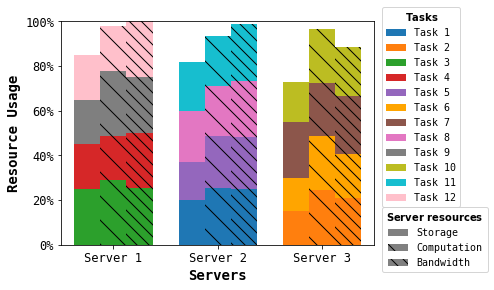

In [8]:
elastic_results = elastic_optimal(tasks, servers, time_limit=20)
minimise_resource_allocation(tasks, servers, time_limit=5)

print_tasks(tasks)
plot_allocation_results(tasks, servers, 'Optimal Elastic Examples')
reset_model(tasks, servers)

### Optimal Non-elastic Solution

Social welfare: 955, percentage tasks allocated: 9
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   27    |   30    |   17    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   22    |   32    |   15    |   None   
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   34    |   28    |   19    | Server 2 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   27    |   24    |   19    |   None   
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   25    |   22    |   22    | Server 1 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   21    |   29    |   18    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   33    |   28    |   19    |   None   
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   30    |   23    |   19    | Server 2 
Task 9  | 120.0 |   100  

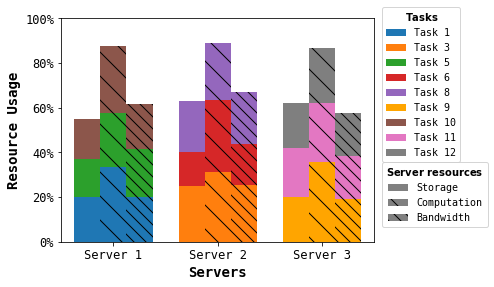

In [9]:
non_elastic_tasks = [NonElasticTask(task, SumSpeedsResourcePriority(), non_elastic_name=False) for task in tasks]
non_elastic_results = non_elastic_optimal(non_elastic_tasks, servers)

print_tasks(non_elastic_tasks)
plot_allocation_results(non_elastic_tasks, servers, 'Optimal Non elastic Examples')
reset_model(tasks, servers)

### Greedy Solution

Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   30    |   23    |   22    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   30    |   22    |   22    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   37    |   26    |   19    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   32    |   17    |   25    | Server 3 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   31    |   19    |   22    | Server 2 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   25    |   24    |   20    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   37    |   21    |   27    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   33    |   20    |   20    | Server 2 
Task 9  | 120.0 |   100

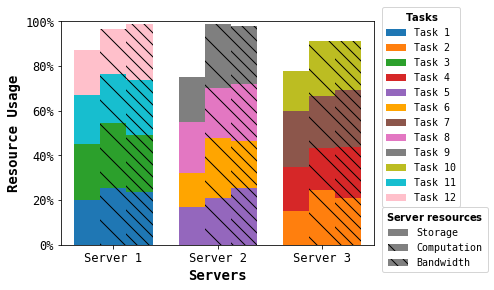

In [10]:
greedy_results = greedy_algorithm(tasks, servers, UtilityDeadlinePerResourcePriority(), 
                                  ProductResources(), SumPowPercentage())

print_tasks(tasks)
plot_allocation_results(tasks, servers, 'Greedy Algorithm Example')
reset_model(tasks, servers)

### Optimal Elastic, Non-elastic and Greedy results

In [11]:
results = {'Elastic': elastic_results, 'Non-elastic': non_elastic_results, 'Greedy Algo': greedy_results}

print(f"{'Name':^11} | Social Welfare | {'Storage':<7} | {'Computation':<11} | {'Bandwidth':<9} | Num Jobs")
for name, result in results.items():
    print(f"{name:<11} | {result.social_welfare:^14} | "
          f"{np.around(np.mean(list(result.server_storage_used.values())), 3):^7} | "
          f"{np.around(np.mean(list(result.server_computation_used.values())), 3):^11} | "
          f"{np.around(np.mean(list(result.server_bandwidth_used.values())), 3):^9} | "
          f"{list(result.server_num_tasks_allocated.values())}")

   Name     | Social Welfare | Storage | Computation | Bandwidth | Num Jobs
Elastic     |      1200      |   0.8   |     1.0     |   0.989   | [4, 4, 4]
Non-elastic |      955       |   0.6   |    0.878    |   0.622   | [3, 3, 3]
Greedy Algo |      1200      |   0.8   |    0.956    |   0.96    | [4, 4, 4]


## Model to latex converter

In [12]:
print('Name    & $v_j$ & $s_j$ & $w_j$ & $r_j$ & $d_j$ & $s^{\'}_j$ & $w^{\'}_j$ & $r^{\'}_j$ \\\\ \hline')
for task in non_elastic_tasks:
    print(f'{task.name:<7} & {task.value:<5} & {task.required_storage:<5} & {task.required_computation:<5} & '
          f'{task.required_results_data:<5} & {task.deadline:<5} & '
          f'{task.loading_speed:<9} & {task.compute_speed:<9} & {task.sending_speed:<9} \\\\ \\hline')

print()
print('Name     & $S_i$ & $W_i$ & $R_i$ \\\\ \hline')
for server in servers:    
    print(f'{server.name} & {server.storage_capacity:<5} & ' 
          f'{server.computation_capacity:<5} & {server.bandwidth_capacity:<5} \\\\ \\hline')

Name    & $v_j$ & $s_j$ & $w_j$ & $r_j$ & $d_j$ & $s^{'}_j$ & $w^{'}_j$ & $r^{'}_j$ \\ \hline
Task 1  & 100   & 100   & 100   & 50    & 10    & 27        & 30        & 17        \\ \hline
Task 2  & 90    & 75    & 125   & 40    & 10    & 22        & 32        & 15        \\ \hline
Task 3  & 110   & 125   & 110   & 45    & 10    & 34        & 28        & 19        \\ \hline
Task 4  & 75    & 100   & 75    & 60    & 10    & 27        & 24        & 19        \\ \hline
Task 5  & 125   & 85    & 90    & 55    & 10    & 25        & 22        & 22        \\ \hline
Task 6  & 100   & 75    & 120   & 40    & 10    & 21        & 29        & 18        \\ \hline
Task 7  & 80    & 125   & 100   & 50    & 10    & 33        & 28        & 19        \\ \hline
Task 8  & 110   & 115   & 75    & 55    & 10    & 30        & 23        & 19        \\ \hline
Task 9  & 120   & 100   & 110   & 60    & 10    & 27        & 32        & 21        \\ \hline
Task 10 & 90    & 90    & 120   & 40    & 10    & 27        